In [2]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler


%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [3]:
#loading data

test = pd.read_csv('test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})

sales = pd.read_csv('sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'float64'})



In [4]:
#join datasets

train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [5]:
print('Train rows: ', train.shape[0])
print('Train columns: ', train.shape[1])

Train rows:  2351233
Train columns:  10


In [6]:
train.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1.00,1.00,-1.00,1.00,1.00
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [7]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2351233.00,2351233.00,2351233.00,2351233.00,2351232.00,2351233.00
mean,11.17,32.84,10145.54,849.85,1.24,39.67
std,7.11,16.29,6328.17,1664.20,2.07,16.82
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,5.00,22.00,4391.00,249.00,1.00,28.00
50%,11.00,31.00,9043.00,399.00,1.00,40.00
75%,17.00,47.00,15638.00,899.00,1.00,55.00
max,24.00,59.00,22169.00,307980.00,1000.00,83.00


In [8]:
#time period of the dataset
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())


Min date from train set: 2013-01-01
Max date from train set: 2015-12-01


In [9]:
#data leakage
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
lk_train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [10]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 2351233
Data set size after leaking: 778956


In [11]:
#data cleaning- Only records with "item_price" > 0.
train = train.query('item_price > 0')

In [12]:
#data preprocessing
# Select only useful features.
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [13]:
# Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [14]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [15]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

In [16]:
#new dataset
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
item_price,10730.00,4775.21,1188.30,5970.00,1490.00
mean_item_price,1532.86,2387.60,594.15,1990.00,1490.00
item_cnt,9.00,0.00,2.00,3.00,1.00
mean_item_cnt,1.29,0.00,1.00,1.00,1.00
transactions,7.00,2.00,2.00,3.00,1.00


In [17]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,4432920.00,16.50,9.81,0.00,8.00,16.50,25.00,33.00
shop_id,4432920.00,31.54,17.76,2.00,16.00,34.00,47.00,59.00
item_id,4432920.00,10726.98,6300.45,30.00,5011.50,10677.50,16064.50,22167.00
item_category_id,4432920.00,3.41,12.61,0.00,0.00,0.00,0.00,83.00
item_price,4432920.00,173.65,2335.15,0.00,0.00,0.00,0.00,515573.59
mean_item_price,4432920.00,65.52,428.39,0.00,0.00,0.00,0.00,29240.00
item_cnt,4432920.00,0.24,3.66,-4.00,0.00,0.00,0.00,1305.00
mean_item_cnt,4432920.00,0.09,0.66,-2.00,0.00,0.00,0.00,1000.00
transactions,4432920.00,0.18,0.94,0.00,0.00,0.00,0.00,31.00


In [18]:
# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

In [19]:
# Grouping data for EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

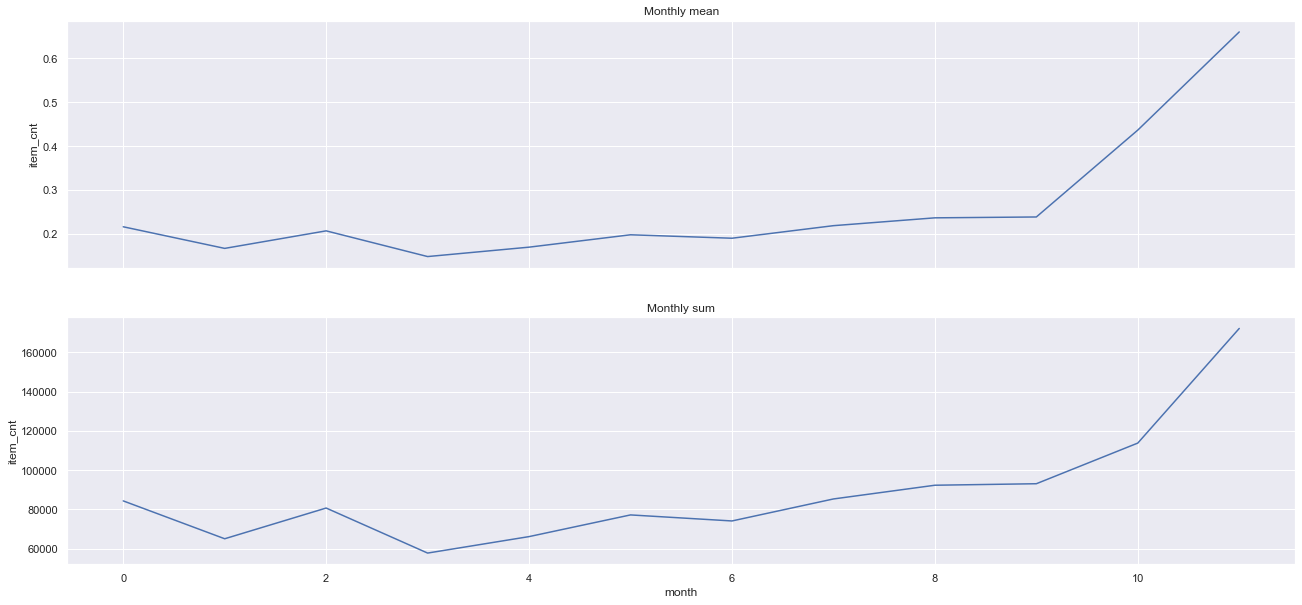

In [20]:
#how sales behave along the year
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

In [21]:
#As we can see we have a trending increase of item sales count (mean) towards the ending of the year.

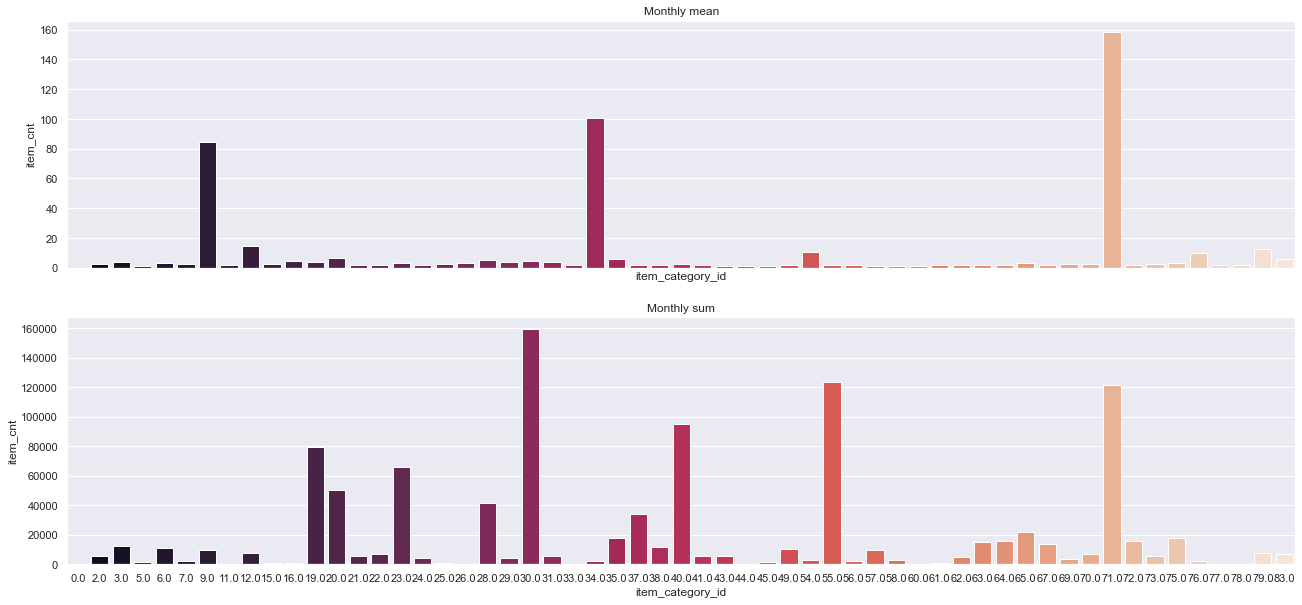

In [22]:
#what categories sell more
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

In [23]:
#Also only few of the categories seems to hold most of the sell count.

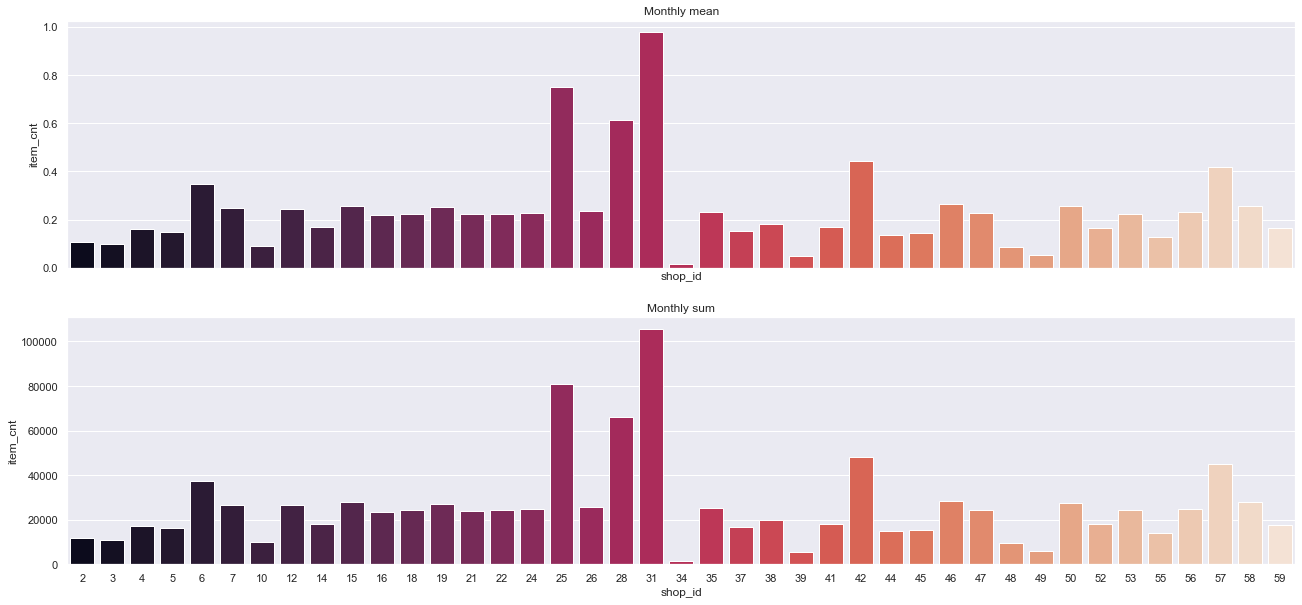

In [24]:
#which shop sells more
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

In [25]:
#Most of the shops have a similar sell rate, but 3 of them have a much higher rate, this may be a indicative of the shop size.

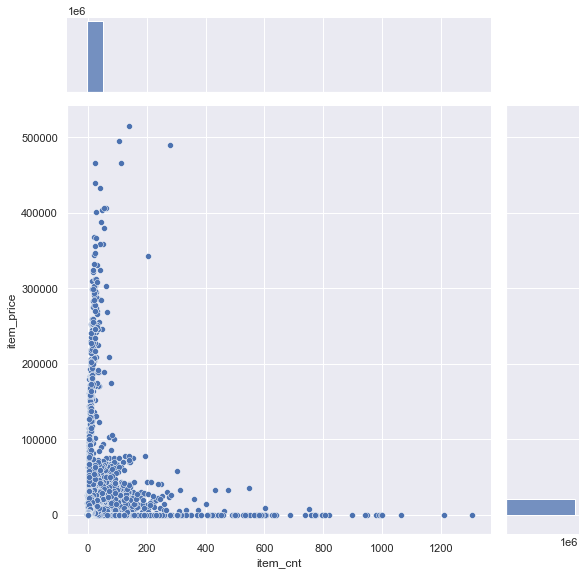

In [26]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()


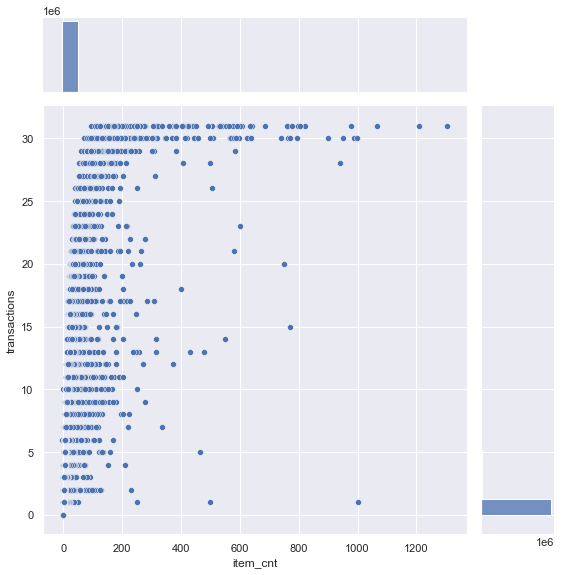

In [27]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

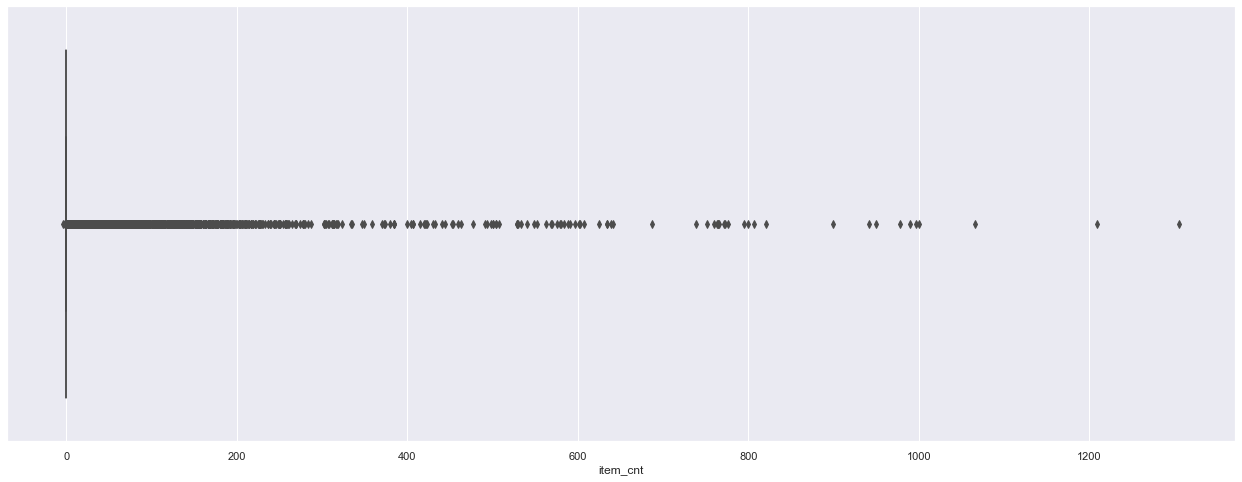

In [28]:
#Feature "item_cnt" distribution.
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()

In [29]:
#Removing outliers
#we treat "item_cnt" > 20 and < 0, "item_price" >= 400000 as outliers, so I'll remove them.

train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')

In [30]:
#Creating the label
#Our label will be the "item_cnt" of the next month, as we are dealing with a forecast problem.

train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [31]:
#Feature engineering
#Unitary item prices.
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)

In [32]:
#Group based features.
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

In [33]:
#How much each item's price changed from its (lowest/highest) historical price.
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

In [34]:
#Rolling window based features (window = 3 months).
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [35]:
#Lag based features.
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [36]:
#Item sales count trend.
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

In [37]:
#Dataset after feature engineering
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
item_price,10730.00,4775.21,1188.30,5970.00,1490.00
mean_item_price,1532.86,2387.60,594.15,1990.00,1490.00
item_cnt,9.00,0.00,2.00,3.00,1.00
mean_item_cnt,1.29,0.00,1.00,1.00,1.00
transactions,7.00,2.00,2.00,3.00,1.00
year,2013.00,2013.00,2013.00,2013.00,2013.00


In [38]:
#Train/validation split
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Train set records: 3255275
Validation set records: 651900
Test set records: 130380
Train set records: 3255275 (74% of complete data)
Validation set records: 651900 (15% of complete data)


In [39]:
#Mean encoding
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [40]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [41]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [42]:
#Build test set
#To predict for "date_block_num" 34, our test set will be block 33
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [43]:
#Replacing missing values.
sets = [X_train, X_validation, X_test]

# This was taking too long.
# Replace missing values with the median of each item.
# for dataset in sets:
#     for item_id in dataset['item_id'].unique():
#         for column in dataset.columns:
#             item_median = dataset[(dataset['item_id'] == item_id)][column].median()
#             dataset.loc[(dataset[column].isnull()) & (dataset['item_id'] == item_id), column] = item_median

# Replace missing values with the median of each shop.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [44]:
# Dropping "item_category_id"
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [45]:
#test set
X_test.head().T

,0,1,2,3,4
shop_id,5.00,5.00,5.00,5.00,5.00
item_id,5037.00,5320.00,5233.00,5232.00,5268.00
item_price,0.00,0.00,0.00,0.00,0.00
mean_item_price,0.00,0.00,0.00,0.00,0.00
item_cnt,0.00,0.00,0.00,0.00,0.00
mean_item_cnt,0.00,0.00,0.00,0.00,0.00
transactions,0.00,0.00,0.00,0.00,0.00
year,2015.00,2015.00,2015.00,2015.00,2015.00
month,9.00,9.00,9.00,9.00,9.00
item_price_unit,0.00,0.00,0.00,0.00,0.00


In [46]:
#modelling the data
# Use only part of features on XGBoost.
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [47]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[04:38:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.02791	validation_1-rmse:0.459389
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.761741	validation_1-rmse:0.221722
[40]	validation_0-rmse:0.754018	validation_1-rmse:0.219945
Stopping. Best iteration:
[32]	validation_0-rmse:0.755718	validation_1-rmse:0.215666



XGBRegressor(colsample_bytree=0.7, eta=0.3, max_depth=8, min_child_weight=1000,
             n_estimators=500, seed=0, subsample=0.7)

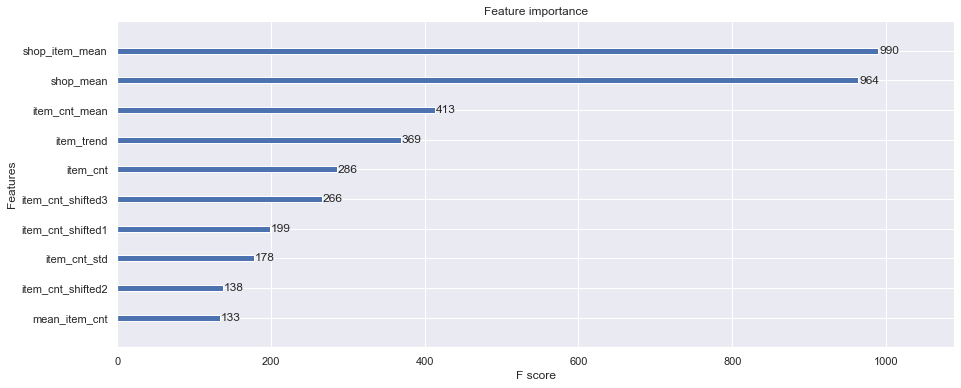

In [48]:
#xgboost featuyre importance
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [49]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

Train rmse: 0.7574291423739353
Validation rmse: 0.21586765822748738


In [71]:
from sklearn.ensemble import RandomForestRegressor
# Use only part of features on random forest.
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [72]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=0)

In [73]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 0.7854547621604868
Validation rmse: 0.025745903978445672


In [78]:
# Use only part of features on linear Regression.
lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

In [79]:
#Normalizing features
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [80]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(n_jobs=-1)

In [81]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

Train rmse: 0.8288813934158087
Validation rmse: 0.10237727001367944


In [82]:
#Clustering models
#KNN Regressor
# Use only part of features on KNN.
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

In [83]:
#Normalizing features
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [84]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(leaf_size=13, n_jobs=-1, n_neighbors=9)

In [85]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Train rmse: 0.570787954400659
Validation rmse: 0.21185977308306014


In [86]:
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(xgb_val_pred, columns=['xgbm'])
first_level['Random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head(20)

,xgbm,Random_forest,linear_regression,knn,label
0,0.44,0.00,0.05,0.00,0
1,0.67,0.00,0.05,0.67,0
2,0.06,0.00,0.05,0.00,0
3,0.80,0.00,0.05,0.00,0
4,0.60,0.00,0.05,0.33,0
5,0.60,0.00,0.05,0.33,0
6,0.46,0.00,0.05,0.44,0
7,0.06,0.01,0.05,0.00,0
8,0.39,0.00,0.05,0.11,0
9,0.88,0.00,0.05,1.33,0


In [88]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(xgb_test_pred, columns=['xgbm'])
first_level_test['Random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,xgbm,Random_forest,linear_regression,knn
0,0.19,0.00,0.07,0.11
1,0.06,0.03,0.07,0.11
2,0.06,0.03,0.07,0.11
3,0.06,0.03,0.07,0.11
4,0.06,0.03,0.07,0.11


In [89]:
meta_model = LinearRegression(n_jobs=-1)

In [90]:
# Drop label from dataset.
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)

LinearRegression(n_jobs=-1)

In [91]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [92]:
#Ensemble model metrics on validation set.
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

Train rmse: 0.0


In [93]:
#Output dataframe.
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)


,ID,item_cnt_month
0,0,0.00
1,1,0.00
2,2,0.00
3,3,0.00
4,4,0.00
5,5,0.00
6,6,0.00
7,7,0.00
8,8,0.00
9,9,0.00


In [66]:
from sklearn.model_selection import GridSearchCV
import numpy as np


param_grid = {'max_depth':[8], 
                         'n_estimators':[500], 
                         'min_child_weight':[1000],  
                         'colsample_bytree':[0.7], 
                         'subsample':[0.7], 
                         'eta':[0.3], 
                         'seed':[0]}


model = XGBRegressor()

mod = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=2)
mod.fit(xgb_train, Y_train)
#yp1 = np.expm1(mod.predict(xgb_test))
#y_pred.append(yp1)
print("Best parameters found: ", mod.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(mod.best_score_)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] colsample_bytree=0.7, eta=0.3, max_depth=8, min_child_weight=1000, n_estimators=500, seed=0, subsample=0.7 
[04:57:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.7, eta=0.3, max_depth=8, min_child_weight=1000, n_estimators=500, seed=0, subsample=0.7, total=45.0min
[CV] colsample_bytree=0.7, eta=0.3, max_depth=8, min_child_weight=1000, n_estimators=500, seed=0, subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 45.0min remaining:    0.0s


[05:42:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.7, eta=0.3, max_depth=8, min_child_weight=1000, n_estimators=500, seed=0, subsample=0.7, total=43.2min
[CV] colsample_bytree=0.7, eta=0.3, max_depth=8, min_child_weight=1000, n_estimators=500, seed=0, subsample=0.7 
[06:25:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.7, eta=0.3, max_depth=8, min_child_weight=1000, n_estimators=500, seed=0, subsample=0.7, total=44.8min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 133.0min finished


[07:10:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found:  {'colsample_bytree': 0.7, 'eta': 0.3, 'max_depth': 8, 'min_child_weight': 1000, 'n_estimators': 500, 'seed': 0, 'subsample': 0.7}
Lowest RMSE found:  0.632976627203934


In [67]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'n_jobs':[-1]}


model = LinearRegression()

mod = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=2, verbose=2)
mod.fit(lr_train, Y_train)

print("Best parameters found: ", mod.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(mod.best_score_)))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_jobs=-1 .......................................................
[CV] ........................................ n_jobs=-1, total=   3.5s
[CV] n_jobs=-1 .......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] ........................................ n_jobs=-1, total=   2.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s finished


Best parameters found:  {'n_jobs': -1}
Lowest RMSE found:  0.5677881320689923


In [68]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'n_jobs':[-1],'n_neighbors':[9], 'leaf_size':[13]}


model = KNeighborsRegressor()

mod = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=2, verbose=2)
mod.fit(knn_train, Y_train_sampled)

print("Best parameters found: ", mod.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(mod.best_score_)))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] leaf_size=13, n_jobs=-1, n_neighbors=9 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... leaf_size=13, n_jobs=-1, n_neighbors=9, total=  36.0s
[CV] leaf_size=13, n_jobs=-1, n_neighbors=9 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.0s remaining:    0.0s


[CV] ........... leaf_size=13, n_jobs=-1, n_neighbors=9, total=  25.6s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min finished


Best parameters found:  {'leaf_size': 13, 'n_jobs': -1, 'n_neighbors': 9}
Lowest RMSE found:  0.645426318920781


In [94]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'n_estimators':[50], 'max_depth':[7], 'random_state':[0],'n_jobs':[-1]}


model = RandomForestRegressor()

mod = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=2, verbose=2)
mod.fit(rf_train, Y_train)

print("Best parameters found: ", mod.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(mod.best_score_)))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=7, n_estimators=50, n_jobs=-1, random_state=0 .........
[CV]  max_depth=7, n_estimators=50, n_jobs=-1, random_state=0, total= 7.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.7min remaining:    0.0s


[CV] max_depth=7, n_estimators=50, n_jobs=-1, random_state=0 .........
[CV]  max_depth=7, n_estimators=50, n_jobs=-1, random_state=0, total=49.6min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 57.3min finished


Best parameters found:  {'max_depth': 7, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 0}
Lowest RMSE found:  0.599399484249404
